## Import Packages and Load Data

In [ ]:
# before running everything, create a new conda environment with python 3.10 installed 
# conda env create -n "myEnv" python=3.10
# pip install torch torchvision matplotlib seaborn umap-learn umap-learn[plot] xgboost scikit-learn nltk
# conda install numpy pandas 

In [35]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from preprocess import * 
import xgboost
import umap
import umap.plot

In [4]:
train_data = pd.read_csv(os.path.join("data", "train.csv"))
test_data = pd.read_csv(os.path.join("data", "test.csv"))
train_data.dropna(inplace=True)
X, y = train_data.drop(["price"], axis=1), train_data["price"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_test = test_data
X_train, X_val = preprocess(X_train), preprocess(X_val) 

### Boxplots of Postprocessed features

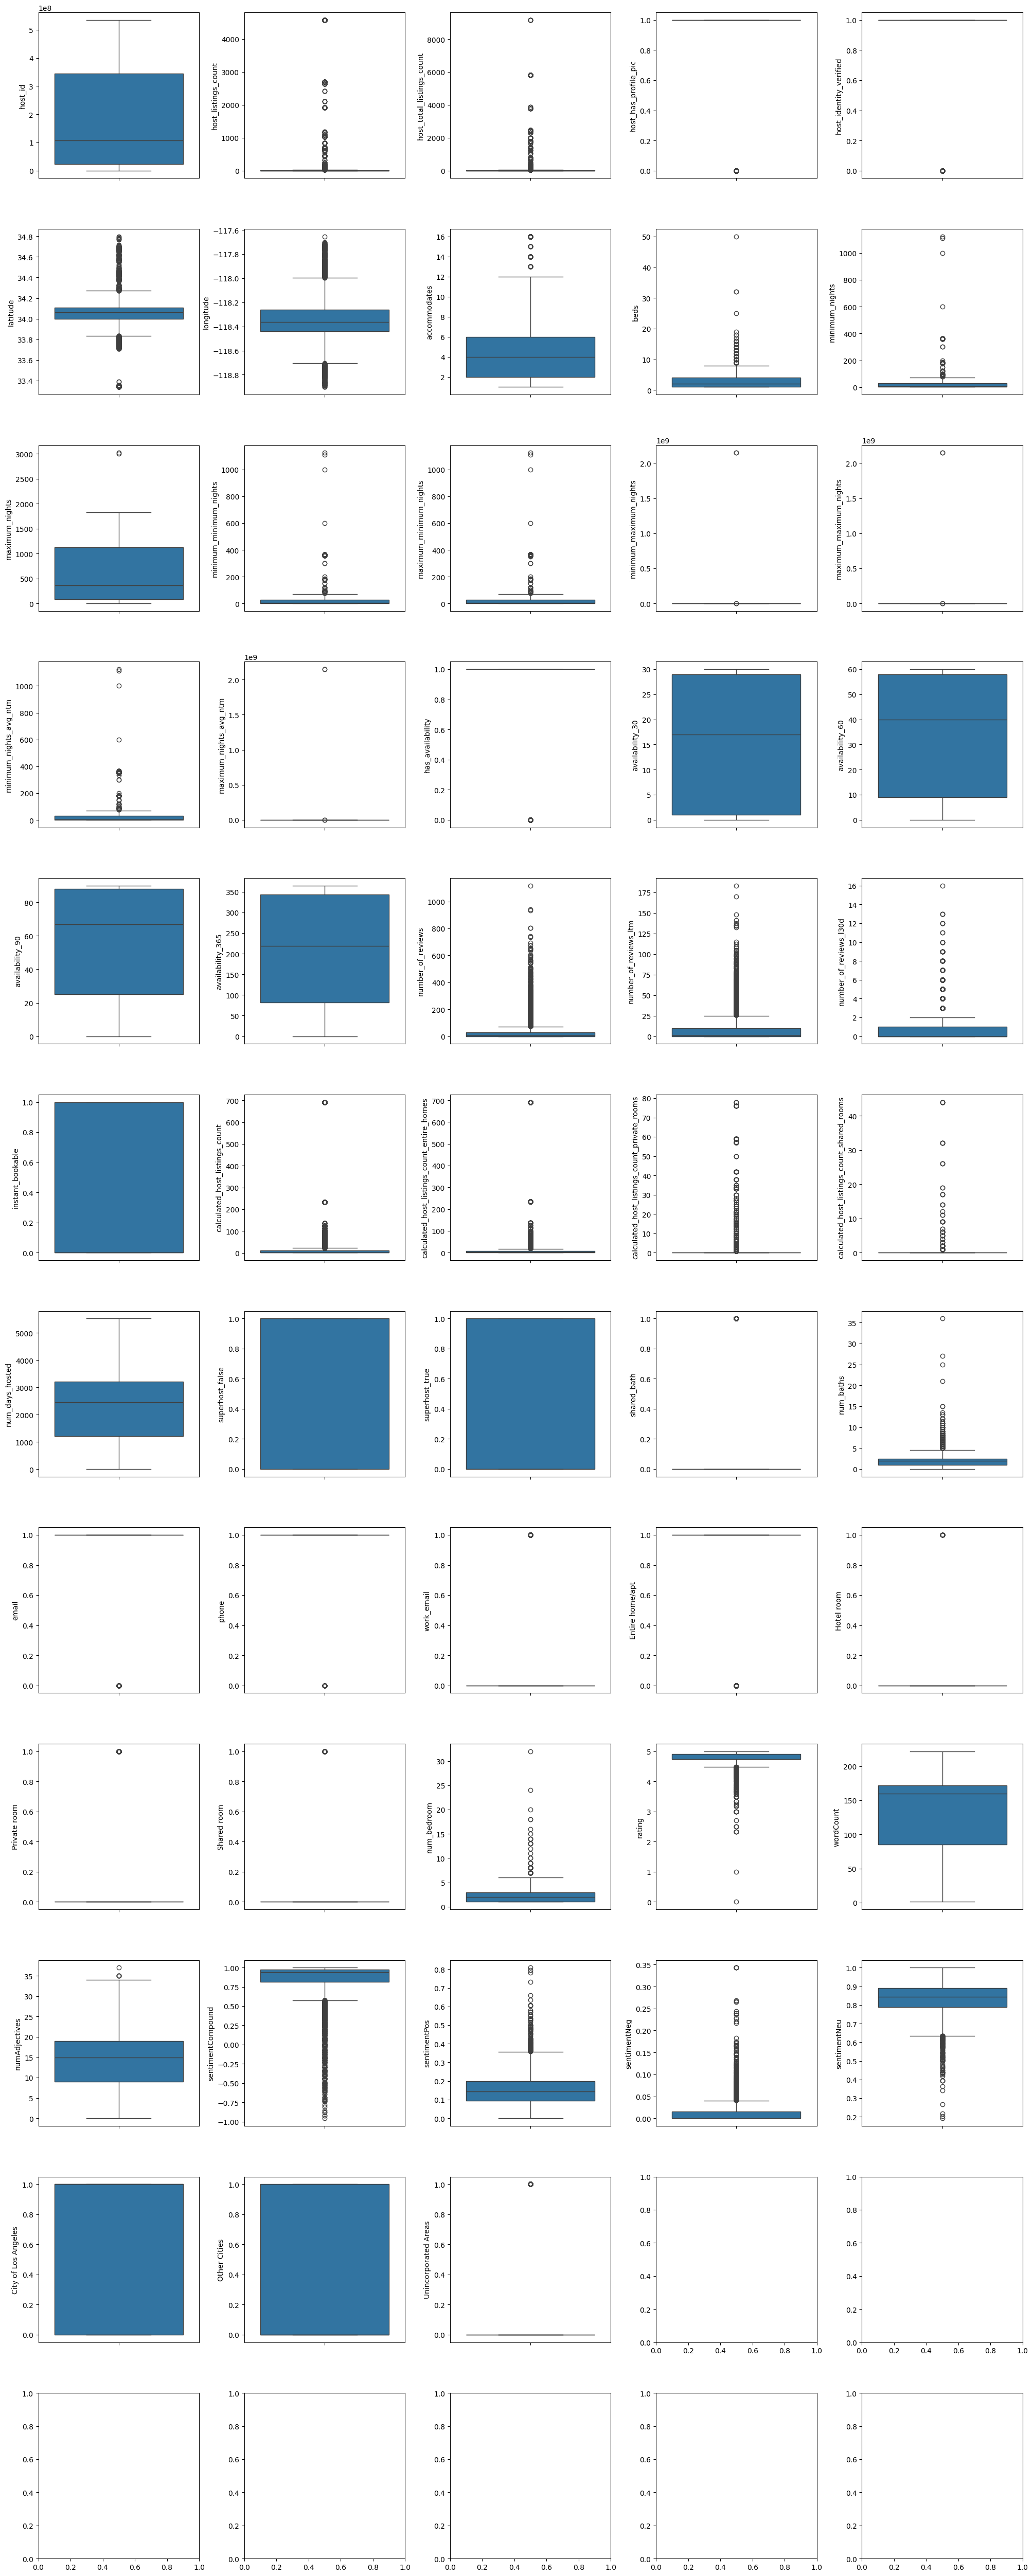

In [29]:
fig, axs = plt.subplots(ncols=5, nrows=12, figsize=(20, 50))
index = 0
axs = axs.flatten()  
for k,v in X_train.items():
    sns.boxplot(y=k, data=X_train, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Visualize Data with UMAP

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: >

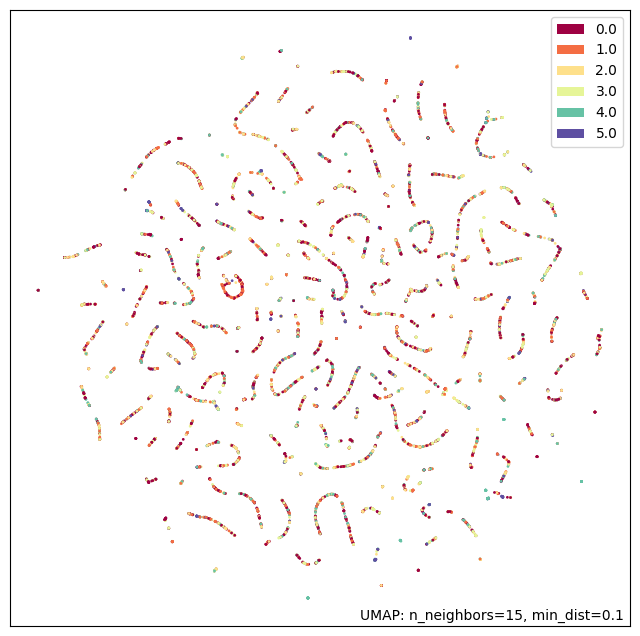

In [5]:
mapper_raw = umap.UMAP().fit(X_train)
umap.plot.points(mapper_raw, labels=y_train)

## Train Neural Net Feature Extractor

### Prepare dataloaders and set device

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class AirBnbDataset(Dataset): 
    
    def __init__(self, X, y): 
        
        # First, train the scaler to the preprocessed train set only 
        scaler = StandardScaler() 
        scaler.fit(X_train) 
        
        # now, convert this pandas dataframe to a numpy array and scale it 
        X = X.to_numpy().astype(float)
        X = scaler.transform(X) 
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = y.to_numpy().astype(int)
        self.num_features = self.X.size()[1]
        
    def process_into_tensor(self): 
        scaler = StandardScaler() 
        scaler.fit(X) 
    
    def __len__(self): 
        return self.X.size()[0] 
    
    def __getitem__(self, i): 
        return (self.X[i, :], self.y[i])

trainset = AirBnbDataset(X_train, y_train) 
valset = AirBnbDataset(X_val, y_val)

trainloader = DataLoader(trainset,    # our dataset
                              batch_size=512,    # batch size
                              shuffle=True      # shuffling the data
                            )
valloader = DataLoader(valset, batch_size=512, shuffle=True)

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(), 
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def oneHot(y): 
    one_hot = torch.zeros(len(y), 6)
    for idx, class_num in enumerate(y):
        one_hot[idx, class_num] = 1 
    return one_hot

def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, oneHot(y).to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return loss 
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, oneHot(y).to(device)).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss 

In [53]:
model = NeuralNetwork(trainset.num_features).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),     # which parameters to optimize
    lr=1e-2,                 # learning rate 
    momentum=0.9
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 25
train_losses, val_losses = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(trainloader, model, loss_fn, optimizer, scheduler))
    val_losses.append(test(valloader, model, loss_fn))
    # scheduler.step() 
    # print(f"lr : {optimizer.lr}")
print("Done!")

Epoch 1
-------------------------------
loss: 1.819393  [  512/11740]
Test Error: 
 Accuracy: 27.5%, Avg loss: 1.736552 

Epoch 2
-------------------------------
loss: 1.745942  [  512/11740]
Test Error: 
 Accuracy: 27.5%, Avg loss: 1.641745 

Epoch 3
-------------------------------
loss: 1.664197  [  512/11740]
Test Error: 
 Accuracy: 35.2%, Avg loss: 1.548929 

Epoch 4
-------------------------------
loss: 1.570359  [  512/11740]
Test Error: 
 Accuracy: 39.9%, Avg loss: 1.463656 

Epoch 5
-------------------------------
loss: 1.522847  [  512/11740]
Test Error: 
 Accuracy: 42.1%, Avg loss: 1.389389 

Epoch 6
-------------------------------
loss: 1.367730  [  512/11740]
Test Error: 
 Accuracy: 45.5%, Avg loss: 1.337120 

Epoch 7
-------------------------------
loss: 1.380105  [  512/11740]
Test Error: 
 Accuracy: 46.1%, Avg loss: 1.305837 

Epoch 8
-------------------------------
loss: 1.298374  [  512/11740]
Test Error: 
 Accuracy: 47.7%, Avg loss: 1.279320 

Epoch 9
----------------

## Construct Backbone Network Feature Extractor

In [54]:
# Get just the feature extractor 
model.linear_relu_stack = nn.Sequential(*list(model.linear_relu_stack.children())[:-1])
scaler = StandardScaler() 
scaler.fit(X_train) 


input = X_train.to_numpy().astype(float)
input = scaler.transform(input) 
input = torch.tensor(input, dtype=torch.float32).to(device)
X_train_features = model(input).detach().cpu().numpy()

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Axes: >

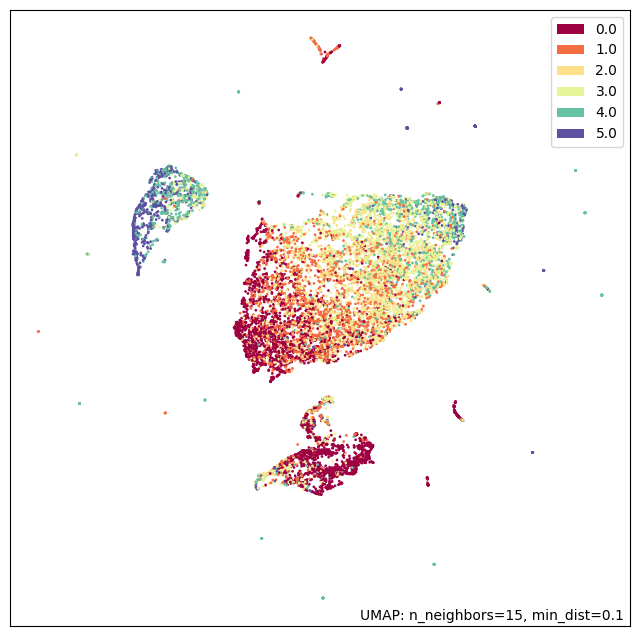

In [55]:
mapper_extracted = umap.UMAP().fit(X_train_features)
umap.plot.points(mapper_extracted, labels=y_train)

## Train Classical Models on Transformed Dataset

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


def decisionTree():

    mod = DecisionTreeClassifier()

    hyperparameters = {
        'criterion': ["gini", "entropy"],
        'splitter': ["best", "random"],
        'max_depth': [5, 10, 15, 20, 25, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'log2', 'sqrt']
    }

    clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_mod = clf.fit(X_train_features, y_train)

    print('Best Parameter Estimates:', best_mod.best_estimator_.get_params())

    val_input = X_val.to_numpy().astype(float)
    val_input = scaler.transform(val_input)
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device)

    y_pred = best_mod.predict(model(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))


def svc(): 
    svc = SVC(gamma="auto")

    hyperparameters = {
        "cache_size" : [70, 80, 90, 100], 
        "C": [1.0, 2.0]
    }
    clf = GridSearchCV(svc, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_svc = clf.fit(X_train_features,y_train)

    print('Best hyperparameters:', best_svc.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_svc.predict(model(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    

def knn(): 
    knn = KNeighborsClassifier()

    n_neighbors = list(range(1,50))
    hyperparameters = dict(n_neighbors=n_neighbors)
    clf = GridSearchCV(knn, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_knn = clf.fit(X_train_features,y_train)

    print('Best K neighbors:', best_knn.best_estimator_.get_params())

    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_knn.predict(model(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def gradientBoost(): 
    gbm = GradientBoostingClassifier()

    n_estimators = list([150])
    hyperparameters = dict(n_estimators = n_estimators)
    clf = GridSearchCV(gbm, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_gbm = clf.fit(X_train_features,y_train)

    print('Best Parameters:', best_gbm.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_gbm.predict(model(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def xgBoost(): 
    
    param_grid = {
        'n_estimators' : [10, 30, 50, 70],
        'learning_rate' : [0.01, 0.03, 0.1, 0.3]
    }
    
    
    xgb = xgboost.XGBClassifier(
        objective="multi:softmax"
    )
    
    clf = GridSearchCV(xgb, param_grid, cv=5, verbose=3, n_jobs=20, scoring="accuracy")
    
    best_xgb = clf.fit(X_train_features, y_train)
    
    print('Best Parameters:', best_xgb.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_xgb.predict(model(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def adaBoost(): 
    
    param_grid = {
        'n_estimators' : [10, 30, 50, 70],
        'learning_rate' : [0.01, 0.03, 0.1, 0.3]
    }

    # Adaboost with DecisionTree as base estimator
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier()
    )

    clf = GridSearchCV(ada, param_grid, cv=5, verbose=3, n_jobs=20, scoring="accuracy")
    
    best_ada = clf.fit(X_train_features, y_train)
    
    print('Best Parameters:', best_ada.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_ada.predict(model(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    

def randomForest(): 
    mod = RandomForestClassifier()

    hyperparameters = {
        'n_estimators': [300, 400],
        'class_weight' : [None], 
        'max_depth': [5, 10, 15, 20, 25, 30],
        # 'min_samples_split': [5, 10],
        # 'min_samples_leaf': [1, 2, 4],
        # 'max_features': ['log2', 'sqrt'], 
        # 'criterion': ["gini", "entropy", "log_loss"]
    }
    clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_mod = clf.fit(X_train_features,y_train)

    print('Best Parameter Estimates:', best_mod.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_mod.predict(model(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

In [57]:
decisionTree()

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV 1/5] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=random;, score=0.502 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=random;, score=0.502 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=random;, score=0.518 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=random;, score=0.491 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=random;, score=0.494 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5, splitter=random;, score=0.494 total time=   0.0s
[CV 2/5] END criterion=gini, m

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [58]:
randomForest()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 4/5] END class_weight=None, max_depth=5, n_estimators=300;, score=0.518 total time=   6.2s
[CV 5/5] END class_weight=None, max_depth=5, n_estimators=300;, score=0.511 total time=   6.3s
[CV 1/5] END class_weight=None, max_depth=5, n_estimators=300;, score=0.534 total time=   7.1s
[CV 3/5] END class_weight=None, max_depth=5, n_estimators=300;, score=0.539 total time=   7.5s
[CV 2/5] END class_weight=None, max_depth=5, n_estimators=300;, score=0.537 total time=   7.6s
[CV 4/5] END class_weight=None, max_depth=5, n_estimators=400;, score=0.519 total time=   8.4s
[CV 1/5] END class_weight=None, max_depth=5, n_estimators=400;, score=0.539 total time=   8.4s
[CV 5/5] END class_weight=None, max_depth=5, n_estimators=400;, score=0.514 total time=   9.3s
[CV 2/5] END class_weight=None, max_depth=5, n_estimators=400;, score=0.536 total time=   9.8s
[CV 3/5] END class_weight=None, max_depth=5, n_estimators=400;, score=0.541 total ti

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [59]:
svc()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 2/5] END ..............C=1.0, cache_size=80;, score=0.538 total time=   5.2s
[CV 4/5] END ..............C=1.0, cache_size=90;, score=0.520 total time=   5.2s
[CV 5/5] END ..............C=1.0, cache_size=70;, score=0.509 total time=   5.5s
[CV 5/5] END .............C=1.0, cache_size=100;, score=0.509 total time=   5.9s
[CV 3/5] END .............C=1.0, cache_size=100;, score=0.534 total time=   5.9s
[CV 2/5] END ..............C=1.0, cache_size=90;, score=0.538 total time=   6.3s
[CV 1/5] END ..............C=1.0, cache_size=80;, score=0.530 total time=   6.4s
[CV 5/5] END ..............C=1.0, cache_size=80;, score=0.509 total time=   6.6s
[CV 3/5] END ..............C=1.0, cache_size=90;, score=0.534 total time=   6.8s
[CV 3/5] END ..............C=1.0, cache_size=70;, score=0.534 total time=   6.9s
[CV 1/5] END .............C=1.0, cache_size=100;, score=0.530 total time=   7.1s
[CV 4/5] END .............C=1.0, cache_size=100;,

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0    0.71429   0.80846   0.75846       804
         1.0    0.40872   0.45422   0.43027       557
         2.0    0.36594   0.19650   0.25570       514
         3.0    0.39669   0.56031   0.46452       514
         4.0    0.41353   0.35032   0.37931       314
         5.0    0.72464   0.43103   0.54054       232

    accuracy                        0.51175      2935
   macro avg    0.50397   0.46681   0.47147      2935
weighted avg    0.50832   0.51175   0.49886      2935



In [60]:
knn()

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 3/5] END .....................n_neighbors=4;, score=0.498 total time=   0.1s
[CV 4/5] END .....................n_neighbors=4;, score=0.482 total time=   0.1s
[CV 3/5] END .....................n_neighbors=1;, score=0.462 total time=   0.2s
[CV 5/5] END .....................n_neighbors=1;, score=0.450 total time=   0.2s
[CV 2/5] END .....................n_neighbors=1;, score=0.457 total time=   0.2s
[CV 2/5] END .....................n_neighbors=4;, score=0.485 total time=   0.2s
[CV 1/5] END .....................n_neighbors=1;, score=0.455 total time=   0.2s[CV 1/5] END .....................n_neighbors=2;, score=0.455 total time=   0.2s

[CV 4/5] END .....................n_neighbors=1;, score=0.462 total time=   0.2s
[CV 5/5] END .....................n_neighbors=4;, score=0.483 total time=   0.2s
[CV 2/5] END .....................n_neighbors=2;, score=0.469 total time=   0.2s
[CV 3/5] END .....................n_neighbors=2

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [49]:
gradientBoost()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END ..................n_estimators=150;, score=0.517 total time=  34.4s
[CV 1/5] END ..................n_estimators=150;, score=0.517 total time=  34.4s
[CV 2/5] END ..................n_estimators=150;, score=0.531 total time=  34.5s
[CV 4/5] END ..................n_estimators=150;, score=0.514 total time=  34.6s
[CV 3/5] END ..................n_estimators=150;, score=0.526 total time=  34.7s
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

         0.0    0.73409

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [61]:
adaBoost()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.445 total time=   0.7s
[CV 3/5] END learning_rate=0.01, n_estimators=70;, score=0.440 total time=   0.7s
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.447 total time=   0.7s
[CV 1/5] END learning_rate=0.01, n_estimators=70;, score=0.448 total time=   0.7s
[CV 1/5] END learning_rate=0.01, n_estimators=30;, score=0.450 total time=   0.7s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.428 total time=   0.7s
[CV 5/5] END learning_rate=0.01, n_estimators=30;, score=0.417 total time=   0.7s
[CV 4/5] END learning_rate=0.01, n_estimators=10;, score=0.444 total time=   0.7s
[CV 2/5] END learning_rate=0.01, n_estimators=30;, score=0.424 total time=   0.7s
[CV 3/5] END learning_rate=0.01, n_estimators=10;, score=0.440 total time=   0.7s
[CV 3/5] END learning_rate=0.01, n_estimators=30;, score=0.439 total time=   0.7s
[CV 4/5] END learning_rate=0.01, n_es

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [62]:
xgBoost()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.504 total time=   0.7s
[CV 2/5] END learning_rate=0.01, n_estimators=10;, score=0.522 total time=   0.8s
[CV 5/5] END learning_rate=0.01, n_estimators=10;, score=0.506 total time=   1.0s
[CV 3/5] END learning_rate=0.01, n_estimators=10;, score=0.518 total time=   1.0s
[CV 4/5] END learning_rate=0.01, n_estimators=10;, score=0.502 total time=   1.1s
[CV 1/5] END learning_rate=0.03, n_estimators=10;, score=0.516 total time=   0.7s
[CV 2/5] END learning_rate=0.03, n_estimators=10;, score=0.532 total time=   0.8s
[CV 3/5] END learning_rate=0.03, n_estimators=10;, score=0.529 total time=   0.7s
[CV 4/5] END learning_rate=0.03, n_estimators=10;, score=0.509 total time=   0.7s
[CV 5/5] END learning_rate=0.03, n_estimators=10;, score=0.506 total time=   1.0s
[CV 5/5] END learning_rate=0.01, n_estimators=30;, score=0.507 total time=   2.2s
[CV 3/5] END learning_rate=0.01, n_es

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
